<h1><center><font size="6">Robots need help!</font></center></h1>

<img src="https://upload.wikimedia.org/wikipedia/commons/d/df/RobotsMODO.jpg" width="400"></img>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Data exploration</a>   
 - <a href='#31'>Check the data</a>   
 - <a href='#32'>Distribution of target feature `surface`</a>   
 - <a href='#33'>Density plots of features</a>   
- <a href='#4'>Feature engineering</a>
- <a href='#5'>Model</a>
- <a href='#6'>Submission</a>  
- <a href='#7'>References</a>

# <a id='1'>Introduction</a>  

## Competition
In this competition, we willl help robots recognize the floor surface they’re standing on. The floor could be of various types, like carpet, tiles, concrete.

## Data
The data provided by the organizers  is collected IMU sensor data while driving a small mobile robot over different floor surfaces on the university premises.  

## Kernel
In this Kernel we perform EDA on the data, explore with feature engineering and build a predictive model.

# <a id='2'>Prepare for data analysis</a>  


## Load packages


In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

## Load data   

Let's check what data files are available.

In [2]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="../input/careercon/"
else:
    PATH="../input/"
os.listdir(PATH)

['y_train.csv', 'sample_submission.csv', 'X_train.csv', 'X_test.csv']

Let's load the data.

In [3]:
%%time
X_train = pd.read_csv(os.path.join(PATH, 'X_train.csv'))
X_test = pd.read_csv(os.path.join(PATH, 'X_test.csv'))
y_train = pd.read_csv(os.path.join(PATH, 'y_train.csv'))

CPU times: user 1.88 s, sys: 248 ms, total: 2.12 s
Wall time: 2.13 s


In [4]:
print("Train X: {}\nTrain y: {}\nTest X: {}".format(X_train.shape, y_train.shape, X_test.shape))

Train X: (487680, 13)
Train y: (3810, 3)
Test X: (488448, 13)


We can observe that train data and labels have different number of rows.

# <a id='3'>Data exploration</a>  

## <a id='31'>Check the data</a>  

Let's check the train and test set.

In [5]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [6]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [7]:
X_test.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


X_train and X_test datasets have the following entries:  

* series and measurements identifiers: **row_id**, **series_id**, **measurement_number**: these identify uniquely a series and measurement; there are 3809 series, each with max 127 measurements;  
* measurement orientations: **orientation_X**, **orientation_Y**, **orientation_Z**, **orientation_W**;   
* angular velocities: **angular_velocity_X**, **angular_velocity_Y**, **angular_velocity_Z**;
* linear accelerations: **linear_acceleration_X**, **linear_acceleration_Y**, **linear_acceleration_Z**.

y_train has the following columns:  

* **series_id** - this corresponds to the series in train data;  
* **group_id**;  
* **surface** - this is the surface type that need to be predicted.



In [8]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [9]:
missing_data(X_train)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
Total,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [10]:
missing_data(X_test)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
Total,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


There are no missing values in train and test data.

In [11]:
missing_data(y_train)

,series_id,group_id,surface
Total,0,0,0
Percent,0,0,0
Types,int64,int64,object


Also, train labels has no missing data.

In [12]:
X_train.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


In [13]:
X_test.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000
mean,1907.500000,63.500000,0.031996,0.120651,0.018735,0.004024,0.000401,0.013669,-0.036101,0.125433,2.906588,-9.359811
std,1101.585403,36.949327,0.671977,0.714522,0.108481,0.100957,0.114485,0.089440,0.233791,1.832639,2.094727,2.802670
min,0.000000,0.000000,-0.989720,-0.989810,-0.154680,-0.156270,-2.403300,-1.193000,-1.458200,-35.040000,-107.480000,-83.173000
25%,953.750000,31.750000,-0.648130,-0.744503,-0.112660,-0.098435,-0.037396,-0.029865,-0.089842,-0.486233,2.052100,-10.125000
50%,1907.500000,63.500000,0.132910,0.397860,0.057271,0.022654,0.001107,0.007276,-0.008911,0.112490,2.900300,-9.361700
75%,2861.250000,95.250000,0.575270,0.803600,0.124770,0.083706,0.037827,0.051112,0.057876,0.727250,3.758000,-8.582075
max,3815.000000,127.000000,0.989320,0.988940,0.154250,0.152510,3.396600,1.150700,0.960280,36.628000,55.624000,59.633000


In [14]:
y_train.describe()

,series_id,group_id
count,3810.000000,3810.000000
mean,1904.500000,37.601312
std,1099.996591,20.982743
min,0.000000,0.000000
25%,952.250000,19.000000
50%,1904.500000,39.000000
75%,2856.750000,55.000000
max,3809.000000,72.000000


There is the same number of series in X_train and y_train, numbered from 0 to 3809 (total 3810). Each series have 128 measurements.   
Each series in train dataset is part of a group (numbered from 0 to 72, 72 being the half of 128).  
The number of rows in X_train and X_test differs with 6 x 128, 128 being the number of measurements for each group.  

## <a id='32'>Distribution of target feature - surface</a>  


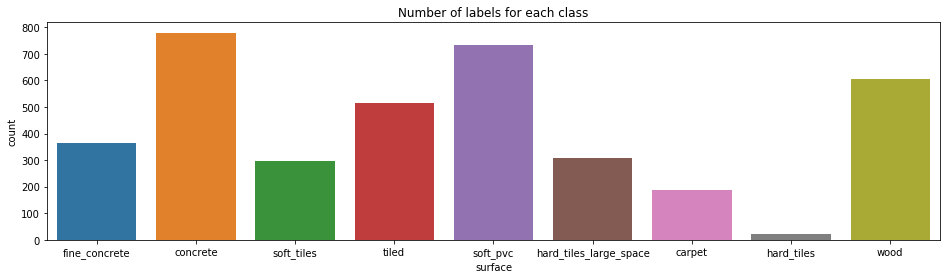

In [15]:
f, ax = plt.subplots(1,1, figsize=(16,4))
g = sns.countplot(y_train['surface'])
g.set_title("Number of labels for each class")
plt.show()    

## <a id='32'>Density plots of features</a>  

Let's show now the density plot of variables in train and test dataset. 

We represent with different colors the distribution for values with different values of **surface**.

In [16]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(16,8))

    for feature in features:
        i += 1
        plt.subplot(2,5,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

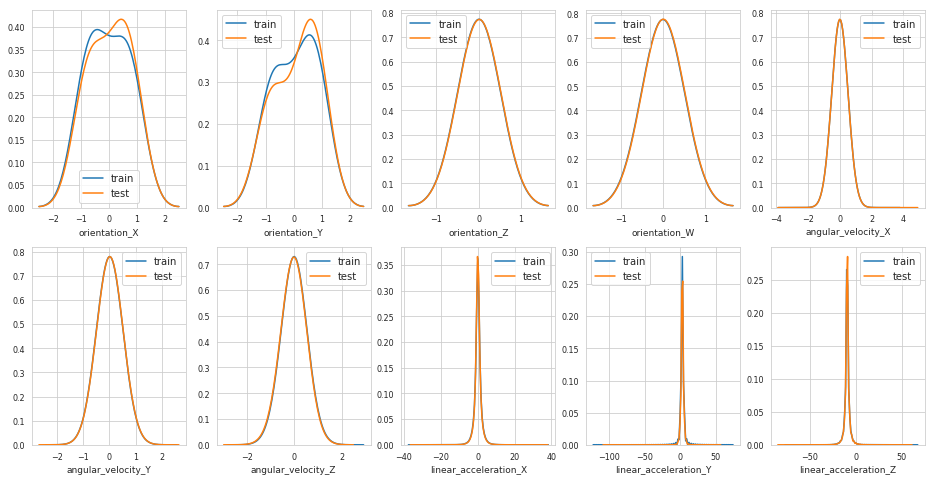

In [17]:
features = X_train.columns.values[3:]
plot_feature_distribution(X_train, X_test, 'train', 'test', features)

In [18]:
def plot_feature_class_distribution(classes,tt, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(5,2,figsize=(16,24))

    for feature in features:
        i += 1
        plt.subplot(5,2,i)
        for clas in classes:
            ttc = tt[tt['surface']==clas]
            sns.kdeplot(ttc[feature], bw=0.5,label=clas)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

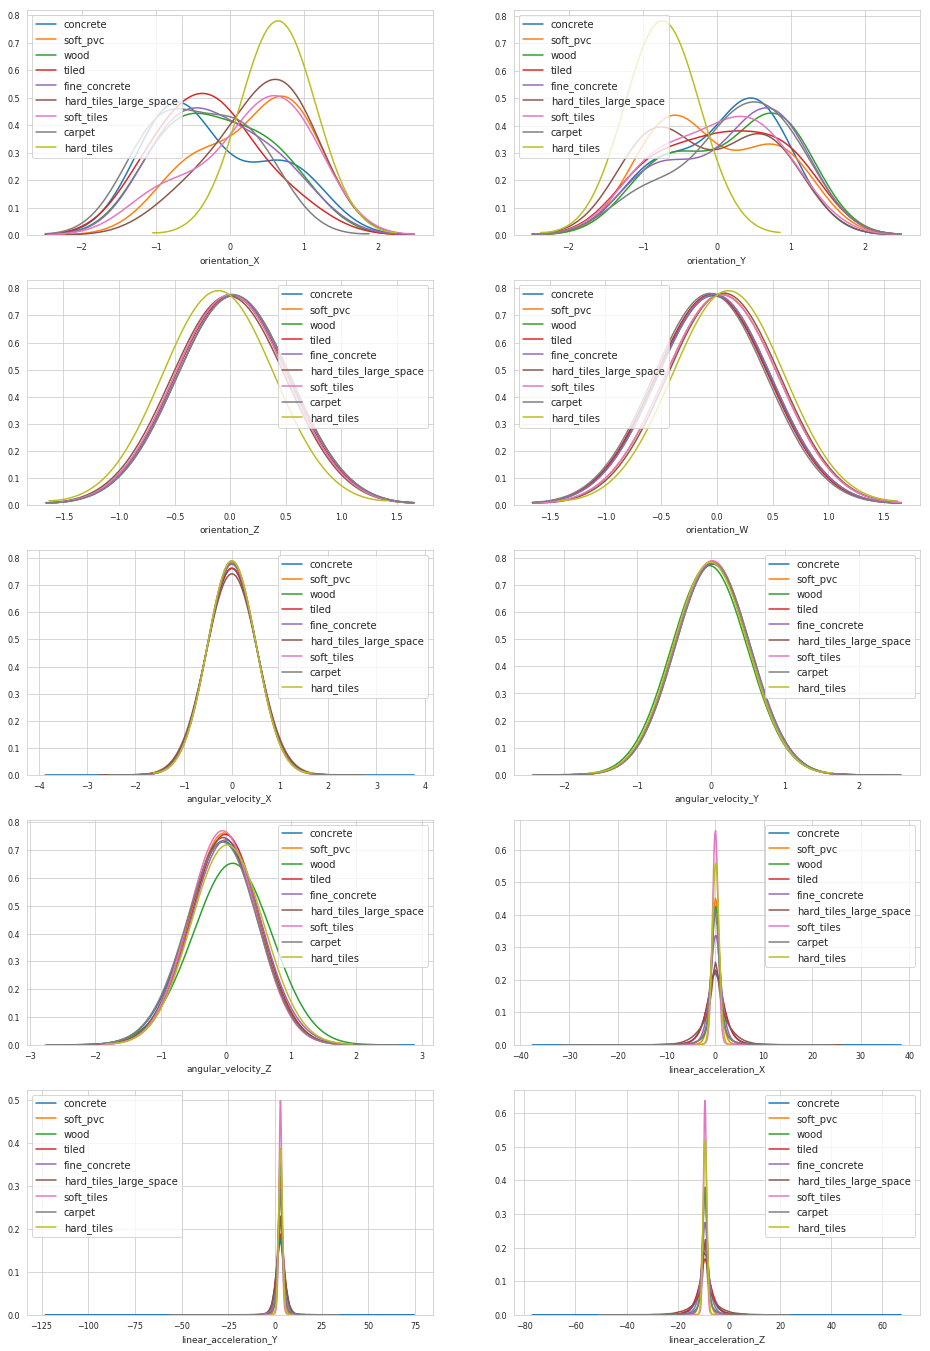

In [19]:
classes = (y_train['surface'].value_counts()).index
tt = X_train.merge(y_train, on='series_id', how='inner')
plot_feature_class_distribution(classes, tt, features)

# <a id='4'>Feature engineering</a>  


This section is heavily borrowing from: https://www.kaggle.com/vanshjatana/help-humanity-by-helping-robots Kernel.

In [20]:
# https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def perform_feature_engineering(actual):
    new = pd.DataFrame()
    actual['total_angular_velocity'] = (actual['angular_velocity_X'] ** 2 + actual['angular_velocity_Y'] ** 2 + actual['angular_velocity_Z'] ** 2) ** 0.5
    actual['total_linear_acceleration'] = (actual['linear_acceleration_X'] ** 2 + actual['linear_acceleration_Y'] ** 2 + actual['linear_acceleration_Z'] ** 2) ** 0.5
    
    actual['acc_vs_vel'] = actual['total_linear_acceleration'] / actual['total_angular_velocity']
    
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    
    actual['total_angle'] = (actual['euler_x'] ** 2 + actual['euler_y'] ** 2 + actual['euler_z'] ** 2) ** 5
    actual['angle_vs_acc'] = actual['total_angle'] / actual['total_linear_acceleration']
    actual['angle_vs_vel'] = actual['total_angle'] / actual['total_angular_velocity']
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))

    def mean_abs_change(x):
        return np.mean(np.abs(np.diff(x)))
    
    for col in actual.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        new[col + '_mean'] = actual.groupby(['series_id'])[col].mean()
        new[col + '_min'] = actual.groupby(['series_id'])[col].min()
        new[col + '_max'] = actual.groupby(['series_id'])[col].max()
        new[col + '_std'] = actual.groupby(['series_id'])[col].std()
        new[col + '_max_to_min'] = new[col + '_max'] / new[col + '_min']
        
        # Change. 1st order.
        new[col + '_mean_abs_change'] = actual.groupby('series_id')[col].apply(mean_abs_change)
        
        # Change of Change. 2nd order.
        new[col + '_mean_change_of_abs_change'] = actual.groupby('series_id')[col].apply(mean_change_of_abs_change)
        
        new[col + '_abs_max'] = actual.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        new[col + '_abs_min'] = actual.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))

    return new

In [21]:
%%time
X_train = perform_feature_engineering(X_train)
X_test = perform_feature_engineering(X_test)

CPU times: user 1min 31s, sys: 728 ms, total: 1min 32s
Wall time: 1min 31s


In [22]:
X_train.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_Y_mean,orientation_Y_min,orientation_Y_max,orientation_Y_std,orientation_Y_max_to_min,orientation_Y_mean_abs_change,orientation_Y_mean_change_of_abs_change,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Z_mean,orientation_Z_min,orientation_Z_max,orientation_Z_std,orientation_Z_max_to_min,orientation_Z_mean_abs_change,orientation_Z_mean_change_of_abs_change,orientation_Z_abs_max,orientation_Z_abs_min,orientation_W_mean,orientation_W_min,orientation_W_max,orientation_W_std,orientation_W_max_to_min,orientation_W_mean_abs_change,orientation_W_mean_change_of_abs_change,orientation_W_abs_max,orientation_W_abs_min,angular_velocity_X_mean,angular_velocity_X_min,angular_velocity_X_max,angular_velocity_X_std,...,euler_y_mean_abs_change,euler_y_mean_change_of_abs_change,euler_y_abs_max,euler_y_abs_min,euler_z_mean,euler_z_min,euler_z_max,euler_z_std,euler_z_max_to_min,euler_z_mean_abs_change,euler_z_mean_change_of_abs_change,euler_z_abs_max,euler_z_abs_min,total_angle_mean,total_angle_min,total_angle_max,total_angle_std,total_angle_max_to_min,total_angle_mean_abs_change,total_angle_mean_change_of_abs_change,total_angle_abs_max,total_angle_abs_min,angle_vs_acc_mean,angle_vs_acc_min,angle_vs_acc_max,angle_vs_acc_std,angle_vs_acc_max_to_min,angle_vs_acc_mean_abs_change,angle_vs_acc_mean_change_of_abs_change,angle_vs_acc_abs_max,angle_vs_acc_abs_min,angle_vs_vel_mean,angle_vs_vel_min,angle_vs_vel_max,angle_vs_vel_std,angle_vs_vel_max_to_min,angle_vs_vel_mean_abs_change,angle_vs_vel_mean_change_of_abs_change,angle_vs_vel_abs_max,angle_vs_vel_abs_min
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75953,-0.75822,0.000363,0.998275,0.000015,2.380952e-07,0.75953,0.75822,-0.634008,-0.63456,-0.63306,0.000471,0.997636,0.000018,0.000000e+00,0.63456,0.63306,-0.105474,-0.106140,-0.104610,0.000432,0.985585,0.000051,7.936508e-08,0.106140,0.104610,-0.106470,-0.107050,-0.105590,0.000389,0.986362,0.000042,4.761905e-07,0.107050,0.105590,-0.002481,-0.16041,0.107650,0.052800,...,0.000065,5.652055e-07,0.025795,0.023562,1.396035,1.393233,1.397402,0.001221,1.002992,0.000051,1.602451e-07,1.397402,1.393233,101256.698324,100638.015559,102006.152921,378.416210,1.013595,33.501276,0.186413,102006.152921,100638.015559,10296.380999,8090.592033,14292.161203,1122.040965,1.766516,742.697670,3.958445,14292.161203,8090.592033,2.278501e+06,6.255962e+05,9.597909e+06,1.409996e+06,15.342019,1.198969e+06,8924.000999,9.597909e+06,6.255962e+05
1,-0.958606,-0.95896,-0.95837,0.000151,0.999385,0.000023,-4.761905e-07,0.95896,0.95837,0.241867,0.24074,0.24270,0.000499,1.008142,0.000070,1.587302e-07,0.24270,0.24074,0.031650,0.030504,0.032341,0.000508,1.060222,0.000048,3.253968e-07,0.032341,0.030504,-0.146876,-0.148090,-0.145870,0.000521,0.985009,0.000103,-1.984127e-06,0.148090,0.145870,0.004605,-0.25480,0.283420,0.092309,...,0.000087,3.159478e-10,0.012073,0.009109,-0.492731,-0.494641,-0.490164,0.001131,0.990949,0.000147,1.303804e-07,0.494641,0.490164,39610.092158,39274.478466,39889.426536,151.936737,1.015658,29.027896,-0.452778,39889.426536,39274.478466,4062.512107,2339.913394,6783.879086,776.901945,2.899201,569.691449,-14.428888,6783.879086,2339.913394,4.613413e+05,1.377975e+05,1.957088e+06,2.979271e+05,14.202636,2.049951e+05,569.164381,1.957088e+06,1.377975e+05
2,-0.512057,-0.51434,-0.50944,0.001377,0.990473,0.000041,0.000000e+00,0.51434,0.50944,-0.846171,-0.84779,-0.84490,0.000785,0.996591,0.000024,-7.142857e-07,0.84779,0.84490,-0.129371,-0.130300,-0.128520,0.000541,0.986339,0.000059,-1.746032e-06,0.130300,0.128520,-0.071082,-0.071535,-0.070378,0.000278,0.983826,0.000044,-1.841270e-06,0.071535,0.070378,0.002646,-0.15271,0.141920,0.060168,...,0.000067,-2.355822e-07,0.012734,0.011795,2.055021,2.049684,

In [23]:
X_test.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_Y_mean,orientation_Y_min,orientation_Y_max,orientation_Y_std,orientation_Y_max_to_min,orientation_Y_mean_abs_change,orientation_Y_mean_change_of_abs_change,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Z_mean,orientation_Z_min,orientation_Z_max,orientation_Z_std,orientation_Z_max_to_min,orientation_Z_mean_abs_change,orientation_Z_mean_change_of_abs_change,orientation_Z_abs_max,orientation_Z_abs_min,orientation_W_mean,orientation_W_min,orientation_W_max,orientation_W_std,orientation_W_max_to_min,orientation_W_mean_abs_change,orientation_W_mean_change_of_abs_change,orientation_W_abs_max,orientation_W_abs_min,angular_velocity_X_mean,angular_velocity_X_min,angular_velocity_X_max,angular_velocity_X_std,...,euler_y_mean_abs_change,euler_y_mean_change_of_abs_change,euler_y_abs_max,euler_y_abs_min,euler_z_mean,euler_z_min,euler_z_max,euler_z_std,euler_z_max_to_min,euler_z_mean_abs_change,euler_z_mean_change_of_abs_change,euler_z_abs_max,euler_z_abs_min,total_angle_mean,total_angle_min,total_angle_max,total_angle_std,total_angle_max_to_min,total_angle_mean_abs_change,total_angle_mean_change_of_abs_change,total_angle_abs_max,total_angle_abs_min,angle_vs_acc_mean,angle_vs_acc_min,angle_vs_acc_max,angle_vs_acc_std,angle_vs_acc_max_to_min,angle_vs_acc_mean_abs_change,angle_vs_acc_mean_change_of_abs_change,angle_vs_acc_abs_max,angle_vs_acc_abs_min,angle_vs_vel_mean,angle_vs_vel_min,angle_vs_vel_max,angle_vs_vel_std,angle_vs_vel_max_to_min,angle_vs_vel_mean_abs_change,angle_vs_vel_mean_change_of_abs_change,angle_vs_vel_abs_max,angle_vs_vel_abs_min
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.025810,-0.026418,-0.025156,0.000284,0.952230,0.000055,-1.269841e-07,0.026418,0.025156,-0.988644,-0.98873,-0.98854,0.000039,0.999808,0.000015,8.811294e-19,0.98873,0.98854,-0.148006,-0.148720,-0.147480,0.000253,0.991662,0.000105,-3.174603e-07,0.148720,0.147480,0.003147,0.002654,0.003609,0.000233,1.359810,0.000044,-5.793651e-07,0.003609,0.002654,0.000994,-0.225610,0.231270,0.083389,...,0.000085,-1.210686e-06,0.014712,0.012999,3.091465,3.090265,3.092815,0.000595,1.000825,0.000113,-4.506257e-07,3.092815,3.090265,1.712803e+06,1.707892e+06,1.718973e+06,2480.785105,1.006489,629.645312,6.856034,1.718973e+06,1.707892e+06,177795.653162,102819.054685,279742.484518,34297.525698,2.720726,27647.603382,76.067273,279742.484518,102819.054685,2.180197e+07,7.369950e+06,1.588678e+08,1.739964e+07,21.556160,1.152085e+07,-376674.228040,1.588678e+08,7.369950e+06
1,-0.932288,-0.933720,-0.931480,0.000564,0.997601,0.000021,-3.968254e-07,0.933720,0.931480,0.330271,0.32661,0.33227,0.001654,1.017330,0.000050,7.936508e-08,0.33227,0.32661,0.043416,0.042283,0.044053,0.000326,1.041861,0.000039,-1.746032e-07,0.044053,0.042283,-0.140968,-0.141790,-0.139940,0.000601,0.986953,0.000078,-2.063492e-06,0.141790,0.139940,0.010602,-0.131980,0.284850,0.080047,...,0.000054,1.065837e-06,0.012780,0.011658,-0.679114,-0.683407,-0.671095,0.003532,0.981985,0.000109,1.825178e-07,0.683407,0.671095,4.595001e+04,4.553931e+04,4.643522e+04,257.115791,1.019673,25.819502,-0.638076,4.643522e+04,4.553931e+04,4659.564651,3423.329362,11419.761540,791.656646,3.335864,336.483422,22.395180,11419.761540,3423.329362,7.217253e+05,1.579567e+05,4.419006e+06,5.852926e+05,27.976065,2.832179e+05,2599.357701,4.419006e+06,1.579567e+05
2,-0.230186,-0.231410,-0.227130,0.001054,0.981505,0.000093,-1.746032e-06,0.231410,0.227130,0.961448,0.96109,0.96217,0.000260,1.001124,0.000030,-7.142857e-07,0.96217,0.96109,0.144340,0.143560,0.145110,0.000335,1.010797,0.000115,-8.730159e-07,0.145110,0.143560,-0.042394,-0.042938,-0.041394,0.000363,0.964041,0.000071,-1.261905e-06,0.042938,0.041394,-0.003484,-0.302820,0.250240,0.105865,...,0.000120,-1.175720e-06,0.016118,0

# <a id='5'>Model</a>  


In [24]:
le = LabelEncoder()
y_train['surface'] = le.fit_transform(y_train['surface'])

In [25]:
X_train.fillna(0, inplace = True)
X_train.replace(-np.inf, 0, inplace = True)
X_train.replace(np.inf, 0, inplace = True)
X_test.fillna(0, inplace = True)
X_test.replace(-np.inf, 0, inplace = True)
X_test.replace(np.inf, 0, inplace = True)

In [26]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

We use a Random Forest Classifier model.

In [27]:
sub_preds_rf = np.zeros((X_test.shape[0], 9))
oof_preds_rf = np.zeros((X_train.shape[0]))
score = 0
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train['surface'])):
    clf =  RandomForestClassifier(n_estimators = 1000, n_jobs = -1)
    clf.fit(X_train.iloc[trn_idx], y_train['surface'][trn_idx])
    oof_preds_rf[val_idx] = clf.predict(X_train.iloc[val_idx])
    sub_preds_rf += clf.predict_proba(X_test) / folds.n_splits
    score += clf.score(X_train.iloc[val_idx], y_train['surface'][val_idx])
    print('Fold: {} score: {}'.format(fold_,clf.score(X_train.iloc[val_idx], y_train['surface'][val_idx])))
print('Avg Accuracy', score / folds.n_splits)

Fold: 0 score: 0.935064935064935
Fold: 1 score: 0.890625
Fold: 2 score: 0.9321148825065274
Fold: 3 score: 0.9397905759162304
Fold: 4 score: 0.916010498687664
Fold: 5 score: 0.9212598425196851
Fold: 6 score: 0.9081364829396326
Fold: 7 score: 0.8970976253298153
Fold: 8 score: 0.8862433862433863
Fold: 9 score: 0.901595744680851
Avg Accuracy 0.9127938973888726


# <a id='6'>Submission</a>  

We submit the solution.

In [28]:
submission = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))
submission['surface'] = le.inverse_transform(sub_preds_rf.argmax(axis=1))
submission.to_csv('rf.csv', index=False)
submission.head(10)

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles
5,5,concrete
6,6,soft_pvc
7,7,concrete
8,8,wood
9,9,wood


# <a id='7'>References</a>    

[1] https://www.kaggle.com/vanshjatana/help-humanity-by-helping-robots-4e306b  
[2] https://www.kaggle.com/artgor/where-do-the-robots-drive  
